In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1 Preparation

* What is the purpose of an activation function in NN in general?  

The activation function maps the input of a neuron to an output.

* What’s the advantage of e.g. sigmoid over the step function (threshold function)?

The logistic (sigmoid) function has a continuous derivative, where the step function has a derivative of 0(undefined at the step)  
* How does sigmoid look like (the formula as well as the graph)?

# $$\sigma(x)=\frac{1}{1+e^{-x}}$$
![Sigmoid function](Logistic-curve.svg)
* What is the derivative of sigmoid?

$$\sigma'(x)=\sigma(x)(1-\sigma(x))$$
### Implement a function sigmoid(x) and a function sigmoidprime(x)

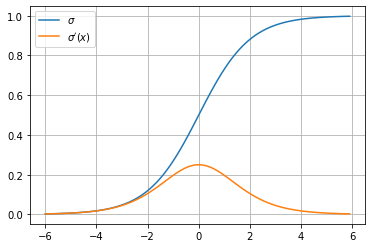

In [117]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoidprime(x):
    return sigmoid(x)*(1-sigmoid(x))

x = np.arange(-6,6,0.1)

fig, ax = plt.subplots()
ax.plot(x, sigmoid(x),label='$\sigma$')
ax.plot(x, sigmoidprime(x),label='$\sigma\'(x)$')
ax.legend()
ax.grid()

assert sigmoid(0)==0.5, "sigmoid function returns wrong value"
assert sigmoidprime(0)==0.25, "sigmoidprime function returns wrong value"

# 2 Data Set
### Input

In [118]:
number_of_inputs = 2

# Create all possible inputs for the number of inputs
data = np.array(np.meshgrid(*[[0, 1]]*number_of_inputs)).T.reshape((2**number_of_inputs,number_of_inputs))
data

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

### Target

In [257]:
# Create target output for each logical function
# Including name of logical function for plotting
t_and = np.array(['AND',[0,0,0,1]])
t_or = np.array(['OR',[0,1,1,1]])
t_nand = np.array(['NAND',[1,1,1,0]])
t_nor = np.array(['NOR',[1,0,0,0]])
t_xor = np.array(['XOR',[0,1,1,0]])

# 3 Perceptron

In [149]:
class Perceptron:
    """Single neuron handling its own weights and bias."""
    
    def __init__(self, input_units, alpha=1, act_fun=sigmoid):
        """Initialize a new neuron with its weights and bias.

        Args:
            input_units (int): Dimensionality of the data coming into this perceptron. 
                In a network of perceptrons this basically represents the 
                number of neurons in the layer before this neuron's layer.                 
            alpha (int): The learning rate of this perceptron.                
            act_fun (function): Function to apply on activation.
        """
        self.input_units = input_units
        self.alpha = alpha
        self.act_func = act_fun
        
        # Randomly assign weights for the input and the bias
        self.weights = np.random.randn(self.input_units + 1) 
        # Initialize variable to store the input
        self.inputs=0
        
    def forward_step(self, inputs):
        """Activate this neuron with a specific input.

        Calculate the weighted sum of inputs and apply the activation function.

        Args:
            inputs (ndarray): Vector of input values.

        Returns:
            float: A number representing the perceptron's activation after 
            calculating the weighted sum of inputs and applying the 
            perceptron's activation function.
        """
        # Store input for update step (inputs = d(l) = a(l-1)+bias)
        self.inputs = np.insert(inputs,0,1) # Insert '1' before the inputs, representing the bias input
        return self.act_func(self.weights @ self.inputs) 
    
    def update(self, delta):
        """Update this neuron's weights by a specific delta.

        Args:
            delta (float): Weight adaptation delta value.
        """ 
        self.weights -= self.alpha * delta * self.inputs

# 4 Multi-Layer Perceptron

In [184]:
class MLP:
    """Network of multiple perceptrons."""
    
    def __init__(self):
        """Initialize a new multi-layer perceptron with a hidden layer consisting of 4 neurons and 1 output neuron."""
        
        # Initialize the neurons of the hidden layer
        self.hidden_layer = [
            Perceptron(2),
            Perceptron(2),
            Perceptron(2),
            Perceptron(2)]
        
        # Initialize the output neuron
        self.output_neuron = Perceptron(len(self.hidden_layer))
        # Initialize variable to store the output
        self.output=0
        # Initialize variable to store the hidden layer activation
        self.hidden_activation=[]
        
    def forward_step(self, inputs):
        """Process the inputs of the multi-layer perceptron through the network.
        
        Args:
            inputs (ndarray): Vector of input values.
        """
        # Compute activations of the neurons in the hidden layer
        self.hidden_activation = [p.forward_step(inputs) for p in self.hidden_layer]
        # Compute the activation of he output neuron
        self.output = self.output_neuron.forward_step(self.hidden_activation)
        
    def backprop_step(self, inputs, target):
        """Performing the backpropagation step of the multi-layer perceptron.
        
        Args:
            inputs (ndarray): Vector of input values.
            target (int): The expected output of the multi-layer perceptron.
        """
        # Compute the delta for the output neuron
        # self.output is sigmoid(d) and sigmoid'(d) = sigmoid(d)*(1-sigmoid(d))
        output_delta = - (target - self.output) * (self.output * (1-self.output))
        # Compute deltas of hidden layer
        hidden_deltas = output_delta * self.output_neuron.weights[-len(self.hidden_layer)] * (np.asarray(self.hidden_activation) * (1-np.asarray(self.hidden_activation)))
                
        # Update the weights of the output neuron
        self.output_neuron.update(output_delta)
        # Update the weights of the neurons in the hidden layer
        for l, d in zip(self.hidden_layer,hidden_deltas):
            l.update(d)
        

# 5 Training

In [259]:
# Initialize the MLP.
mlp = MLP()

# Set the function to train on
training_data = t_xor

# Get the target of the trained function 
target = training_data[1]

# Initialize lists to store epochs, loss, accuracy
epochs=[]
losses=[]
accuracies=[]

for epoch in range(1000):
    epochs.append(epoch)
    
    accuracy = 0
    loss = 0
    
    # Create list to loop through the datapoints in a random order
    rnd_idx_list = np.random.permutation(4)
    for i in rnd_idx_list:
        
        # Perform a forward step with the given input
        mlp.forward_step(data[i])
        # Perform a backpropagation step with the given input and target
        mlp.backprop_step(data[i],target[i])
        
        # Add up the accuracy and loss for each datapoint
        accuracy += int(mlp.output>=0.5) == target[i]
        loss += (target[i]-mlp.output)**2
        
    # Store the average accuracy and loss for each epoch
    accuracies.append(accuracy/4)
    losses.append(loss/4)

# 6 Visualization

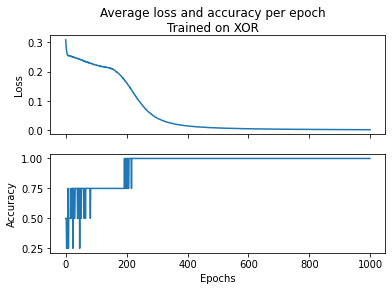

In [261]:
fig, ax = plt.subplots(2,sharex=True)
fig.suptitle(f'Average loss and accuracy per epoch\nTrained on {training_data[0]}')
ax[0].plot(epochs, losses)
ax[1].plot(epochs, accuracies)
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')

plt.show()